# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [34]:
import os
os.chdir(r'F:\Google\Starbucks')

In [35]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [36]:
transcript.head(3)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [39]:
profile.shape

(17000, 5)

In [40]:
transcript.shape

(306534, 4)

# EDA & data cleaning

In [41]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [42]:
# became member on needs to change
profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

## Missing Values
- Profile: There exists a set of customers who have no value for gender & income

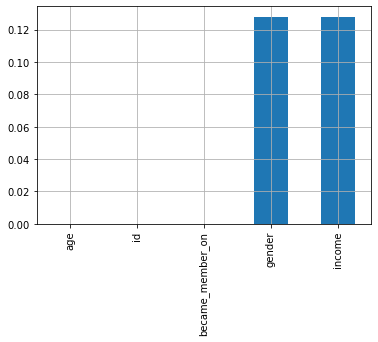

In [43]:
# gender & income null value may correlate, all columns are valid
profile.isnull().mean().sort_values().plot.bar()
plt.grid()

In [44]:
# gender null = income null
(profile.gender.isnull() & profile.income.isnull()).sum()/\
(profile.gender.isnull() | profile.income.isnull()).sum()

1.0

In [45]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [46]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [47]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


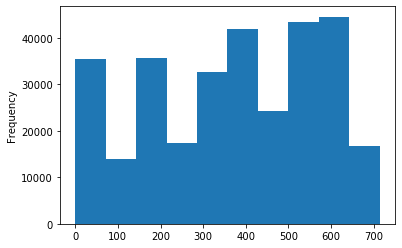

In [48]:
transcript.time.plot.hist()

In [49]:
for channel in ['web','email','mobile','social']:
    portfolio[channel] = portfolio.channels.apply(lambda x: channel in x)

In [50]:
portfolio.iloc[:,6:] = portfolio.iloc[:,6:].astype(int)

In [51]:
portfolio.id.value_counts()

0b1e1539f2cc45b7b9fa7c272da2e1d7    1
5a8bc65990b245e5a138643cd4eb9837    1
2906b810c7d4411798c6938adc9daaa5    1
4d5c57ea9a6940dd891ad53e9dbe8da0    1
2298d6c36e964ae4a3e7e9706d1fb8c2    1
fafdcd668e3743c1bb461111dcafc2a4    1
3f207df678b143eea3cee63160fa8bed    1
ae264e3637204a6fb9bb56bc8210ddfd    1
9b98b8c7a33c4b65b9aebfe6a799e6d9    1
f19421c1d4aa40978ebb69ca19b0e20d    1
Name: id, dtype: int64

In [52]:
profile.age[profile.gender.isnull()]

0        118
2        118
4        118
6        118
7        118
        ... 
16980    118
16982    118
16989    118
16991    118
16994    118
Name: age, Length: 2175, dtype: int64

- Age over 100 is not natural, investigate if there is other problems

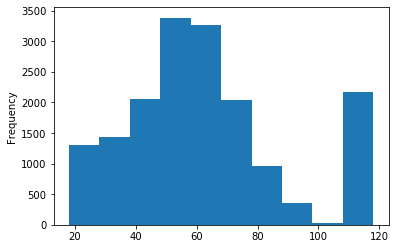

In [53]:
profile.age.plot.hist()

- Now the distribution seems much more plausible

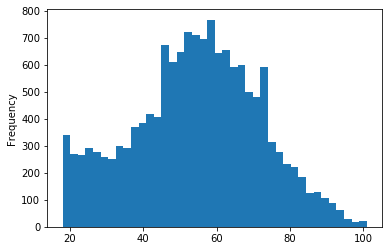

In [54]:
profile.age[profile.age < 118].plot.hist(bins = 40)

In [55]:
# check if age 118, income none and gender unknown occur together
id_118 = profile.id[profile.age == 118]
id_gender = profile.id[profile.gender.isnull()]
id_income = profile.id[profile.income.isnull()]

In [56]:
print(set(id_118) == set(id_gender))
print(set(id_118) == set(id_income))

True
True


- Since members of this group have much less information available and they are large in numbers, I will treat them as a separate group and I will dig into their structure

In [57]:
transcript.isnull().mean()

person    0.0
event     0.0
value     0.0
time      0.0
dtype: float64

In [58]:
transcript.groupby('person').event.value_counts().unstack().mean()

event
offer completed    2.628699
offer received     4.488467
offer viewed       3.429072
transaction        8.381771
dtype: float64

In [59]:
### create a set of new offer id that are easier to understand and visualize later
change_id = pd.DataFrame(portfolio.groupby('offer_type').apply(lambda df: df.reset_index().id))
change_id = change_id.reset_index(level = 1)
change_id['name'] = change_id.index.astype(str) + change_id['level_1'].astype(str)
change_id = change_id[['id','name']].set_index('id')
change_id = change_id.squeeze()
portfolio['id'] = portfolio['id'].apply(lambda x: change_id[x])

In [60]:
def clean_value_col(x):
    ''' clean up the value column of transcript'''
    if 'offer id' in x:
        return change_id[x['offer id']]
    elif 'offer_id' in x:
        return change_id[x['offer_id']]
    elif 'amount' in x:
        return x['amount']
    else:
        return x
transcript.value = transcript.value.apply(lambda x: clean_value_col(x))

In [61]:
profile['new_id'] = np.arange(profile.shape[0])

In [62]:
transcript = pd.merge(transcript, profile[['new_id','id']], how = 'left', left_on = 'person',right_on = 'id')

In [63]:
transcript = transcript.drop(['person','id'],axis = 1)
transcript.columns = ['event','value','time','person']
transcript.to_csv('cleaned_transcript.csv')

In [64]:
profile = profile.drop('id',axis = 1)
#profile = pd.read_csv('cleaned_profile.csv')

In [65]:
transcript.head()

,event,value,time,person
0,offer received,bogo2,0,3
1,offer received,discount0,0,4
2,offer received,discount3,0,5
3,offer received,discount2,0,6
4,offer received,bogo1,0,7


In [67]:
person_event = transcript.groupby('person').apply(lambda x: x.sort_values(by = 'time').drop('person',axis = 1))

In [68]:
person_event.index.names = ['peron','level_1']

In [69]:
person_event.head(2)

event      value  time
peron level_1                                 
0     53174    offer received  discount3   168
      85290      offer viewed  discount3   216

- View happen only once it would seem

In [70]:
person_event.groupby(axis = 0, level = 0).apply(lambda df: (df.event=='offer viewd').sum() > (df.event=='offer received').sum()).sum()

0

In [71]:
person_event.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

- Do not make it too complicated

In [72]:
duration_dict = (portfolio[['id','duration']].set_index('id').squeeze() * 24).to_dict()

In [73]:
duration_dict

{'bogo0': 168,
 'bogo1': 120,
 'informational0': 96,
 'bogo2': 168,
 'discount0': 240,
 'discount1': 168,
 'discount2': 240,
 'informational1': 72,
 'bogo3': 120,
 'discount3': 168}

In [75]:
def counting(df):
    '''Extract Personal information: how many offers are viewed and how many are completed
    Args: 
        df, Dataframe, groupby dataframe
    Return: 
        pd.Series, behavior information of interest
    '''
    df = df.set_index('time').sort_index()
    view_idx = df[df.event.str.contains('view')].index.values
    view_dict = {key: 0 for key in duration_dict.keys()}
    success_dict = {key: 0 for key in duration_dict.keys()}
    type_dict = df[df.event!='transaction'].value.reset_index().drop_duplicates().set_index('time').to_dict()['value']
    #print(view_idx)
    for idx in view_idx:
        offer_type = type_dict[idx]
        view_dict[offer_type] += 1
        idx_max = idx + duration_dict[offer_type]+1
        #print(idx_max - idx)
        if 'information' in offer_type:
            #print(df.loc[idx:idx_max,:].event)
            success_dict[offer_type] += int('transaction' in df.loc[idx:idx_max,:].event.values)
        else:
            #print(df[df.value == offer_type].loc[idx:idx_max,:].event)
            success_dict[offer_type] += int('offer completed' in df[df.value == offer_type].loc[idx:idx_max,:].event.values)
    final_success_dict = {key+'_success' : value for key, value in success_dict.items()}
    view_dict.update(final_success_dict)
    amount = df[df.event == 'transaction'].value.astype(float).sum()
    view_dict['amount'] = amount if amount else 0
    return pd.Series(view_dict).sort_index()

In [76]:
person_df = person_event.reset_index(level = 1).drop('level_1', axis = 1)

In [77]:
test_df = person_df[person_df.index == 6]

### Regression_df: customer behavior dataframe

In [80]:
regression_df = person_df.groupby(axis = 0, level = 0).apply(counting)
regression_df.to_csv('treatment_result.csv')

In [81]:
regression_df.head(2)

,amount,bogo0,bogo0_success,bogo1,bogo1_success,bogo2,bogo2_success,bogo3,bogo3_success,discount0,...,discount1,discount1_success,discount2,discount2_success,discount3,discount3_success,informational0,informational0_success,informational1,informational1_success
peron,,,,,,,,,,,,,,,,,,,,,
0,20.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,77.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Brief Summary
- One group lack information and will be treated separately
- Others have no missing values

## Non-missing group

In [82]:
benchmark_day = profile.became_member_on.apply(lambda x: pd.to_datetime(x, format ='%Y%m%d')).max()
profile['experience'] = profile.became_member_on.apply(lambda x: benchmark_day - pd.to_datetime(x, format ='%Y%m%d'))

In [83]:
no_missing = profile[profile.age != 118].copy()

In [84]:
no_missing.experience = no_missing.experience.dt.days

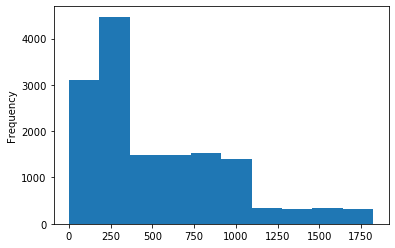

In [85]:
no_missing.experience.plot.hist()

In [86]:
no_missing.head(2)

,gender,age,became_member_on,income,new_id,experience
1,F,55,20170715,112000.0,1,376
3,F,75,20170509,100000.0,3,443


In [87]:
no_missing_regress = pd.merge(no_missing,regression_df,left_on = "new_id",right_index = True)

In [88]:
no_missing_regress.gender = no_missing_regress.gender.apply(lambda x: int(x == 'F'))

In [89]:
no_missing_regress.mean()

gender                    4.134233e-01
age                       5.439352e+01
became_member_on          2.016689e+07
income                    6.540499e+04
new_id                    8.496961e+03
experience                5.224790e+02
amount                    1.170282e+02
bogo0                     3.984486e-01
bogo0_success             1.790219e-01
bogo1                     4.257673e-01
bogo1_success             1.861720e-01
bogo2                     2.363575e-01
bogo2_success             1.407083e-01
bogo3                     4.236088e-01
bogo3_success             2.278583e-01
discount0                 1.552108e-01
discount0_success         9.625632e-02
discount1                 4.296121e-01
discount1_success         2.810793e-01
discount2                 4.307589e-01
discount2_success         2.965936e-01
discount3                 2.364924e-01
discount3_success         1.440809e-01
informational0            2.336594e-01
informational0_success    1.570320e-01
informational1           

In [90]:
no_missing.head(10)

,gender,age,became_member_on,income,new_id,experience
1,F,55,20170715,112000.0,1,376
3,F,75,20170509,100000.0,3,443
5,M,68,20180426,70000.0,5,91
8,M,65,20180209,53000.0,8,167
12,M,58,20171111,51000.0,12,257
13,F,61,20170911,57000.0,13,318
14,M,26,20140213,46000.0,14,1624
15,F,62,20160211,71000.0,15,896
16,M,49,20141113,52000.0,16,1351
18,M,57,20171231,42000.0,18,207


## clustering of non-missing data

### Use only characteristic data, excluding reaction to coupons

In [91]:
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [92]:
X_no_miss = no_missing_regress[['age','gender','income','experience']]

In [93]:
test = X_no_miss.sample(5000)

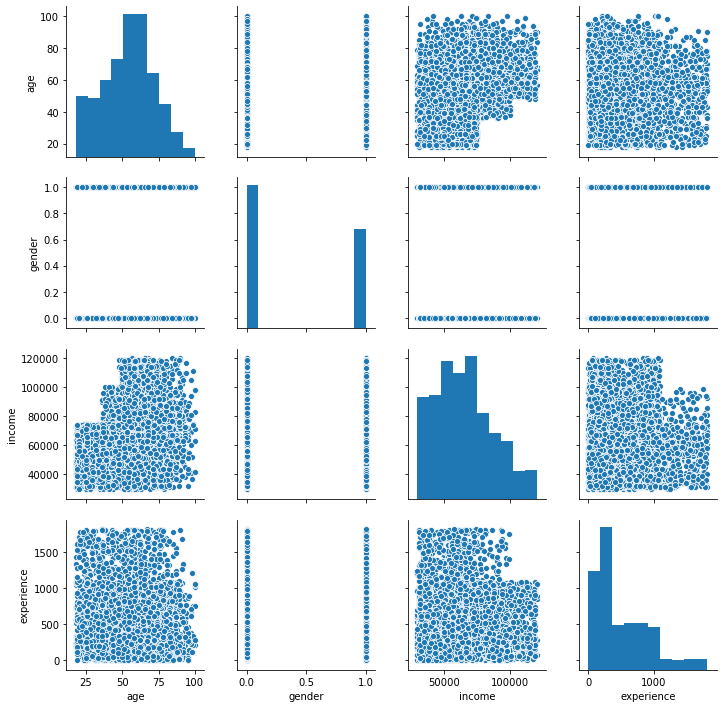

In [94]:
sns.pairplot(test)

In [95]:
scaler = preprocessing.StandardScaler().fit(X = X_no_miss)

In [96]:
X_scaled = scaler.transform(X_no_miss)

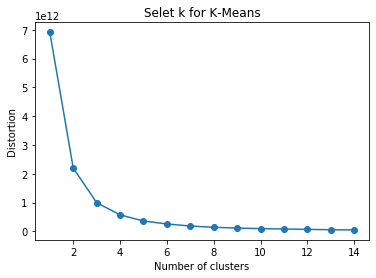

In [97]:
distortions = []
for i in range(1, 15):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=88
    )
    km.fit(X_no_miss)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Selet k for K-Means')
plt.show()


In [98]:
#mds = MDS(n_components=2).fit_transform(test)
X_scaled = scaler.transform(X_no_miss)
tsne = TSNE(n_components=2)
tsne_total = tsne.fit_transform(X_scaled)

In [99]:
tsne = TSNE(n_components=2)

In [100]:
#tsne_result = tsne.fit_transform(new_test)

In [101]:
tsne_total = tsne.fit_transform(X_scaled)

In [104]:
km_cluster = 6
kmeans = KMeans(n_clusters = km_cluster,n_init = 20,random_state = 66)
predicted_no_miss = kmeans.fit_predict(tsne_total)

In [105]:
no_missing_df = pd.DataFrame(data = np.c_[tsne_total,predicted_no_miss], columns = ['PC_1','PC_2','cluster'])

## t-SNE visualization of K-means clustering
- Most clusters align well from visualization
- However, there are some groups that seems clustered falsely
- Meaning the structure is not so "curved"

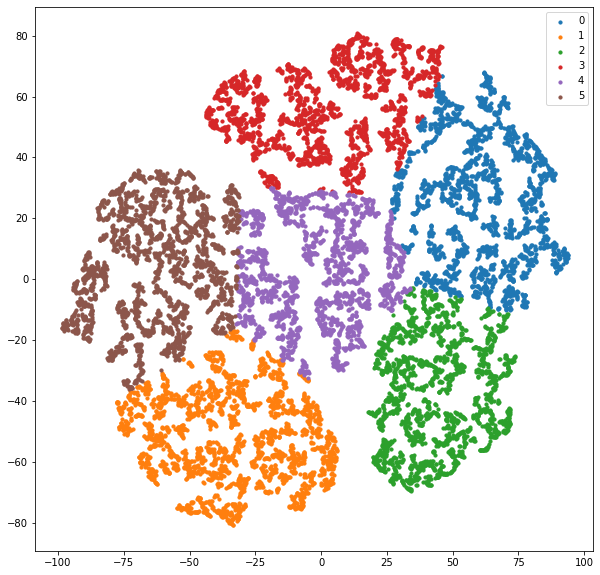

In [106]:
fig,ax = plt.subplots(figsize = (10,10))
for i in range(km_cluster):
    ax.scatter(x='PC_1',y = 'PC_2',s = 10, data = no_missing_df[no_missing_df.cluster == i ],label = str(i))
plt.legend()

In [107]:
no_missing_df.index = X_no_miss.index

In [108]:
no_missing_regress['cluster'] = no_missing_df.cluster

### Visualization of cluster heterogeneity

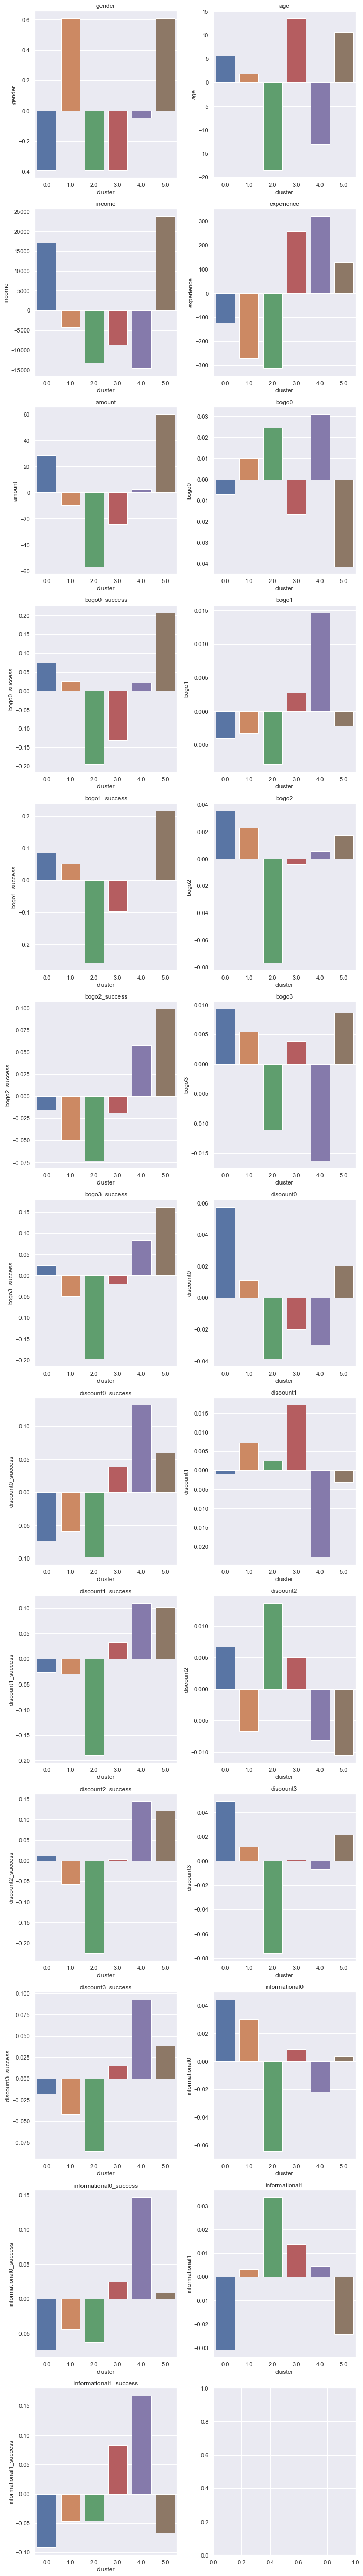

In [109]:
#df_plot = no_missing_regress[['age','gender','income','experience','cluster','amount',]].groupby('cluster').mean()
sns.set();
df_plot = no_missing_regress.drop(['became_member_on','new_id'],axis = 1).groupby('cluster').mean()
n_cols = df_plot.shape[1]
rows = n_cols//2 + (n_cols % 2 >0)
f, axs = plt.subplots(rows,2, figsize=(10,70))
axs = axs.flatten()
for i,col in enumerate(df_plot):
    #print(i)
    if 'success' in col:
        df_plot[col] = df_plot[col]/df_plot[col[:-len('_success')]]
    sns.barplot(x = df_plot.index, y = df_plot[col] - df_plot[col].mean(),ax = axs[i])#.plot(kind = 'bar',ax = axs[i])
    axs[i].set_title(col)
    #plt.show()
plt.tight_layout()

### Use all features available 
- Reveal a potentially more detailed structure

In [110]:
# From number of success to rate of success
df_cluster = no_missing_regress.copy().drop(['became_member_on','new_id','cluster'],axis = 1)
for col in df_cluster:
    if 'success' in col:
        df_cluster[col] = (df_cluster[col]/df_cluster[col[:-len('_success')]]).fillna(0)

In [111]:
X_all = preprocessing.StandardScaler().fit_transform(X = df_cluster)

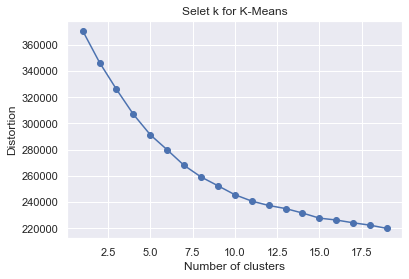

In [112]:
distortions = []
for i in range(1, 20):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=88
    )
    km.fit(X_all)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 20), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Selet k for K-Means')
plt.show()



- No obvious choice of K, simply pick K=12 which should be sufficient to discover all necessary structure

In [113]:
#mds = MDS(n_components=2).fit_transform(test)
tsne_all_feature = TSNE(n_components=2)
tsne_alL_feature_data = tsne.fit_transform(X_all)

In [114]:
km_cluster = 12
kmeans = KMeans(n_clusters = km_cluster,n_init = 20,random_state = 66)
predicted_no_miss = kmeans.fit_predict(X_all)
no_missing_df = pd.DataFrame(data = np.c_[tsne_alL_feature_data,predicted_no_miss], columns = ['PC_1','PC_2','cluster'])

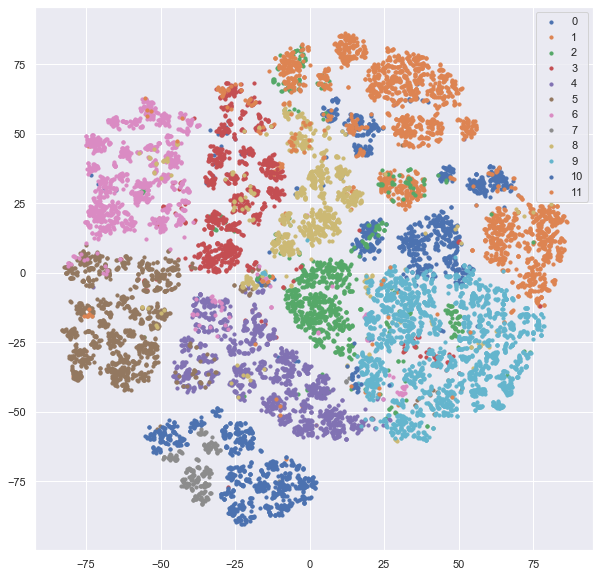

In [115]:
fig,ax = plt.subplots(figsize = (10,10))
for i in range(km_cluster):
    ax.scatter(x='PC_1',y = 'PC_2',s = 10, data = no_missing_df[no_missing_df.cluster == i ],label = str(i))
plt.legend()

- The reuslt is not so good, so, try to combine t-sne with k-means to come up with a classification

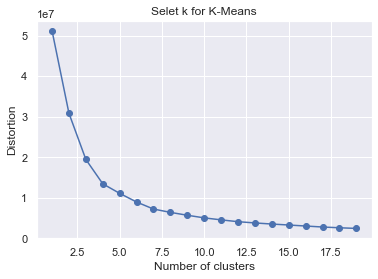

In [116]:
tsne_all_feature_data = tsne_alL_feature_data.copy()
distortions = []
for i in range(1, 20):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=88
    )
    km.fit(tsne_all_feature_data)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 20), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Selet k for K-Means')
plt.show()



- K = 8 should be sufficient

In [117]:
K_tsne = 8
kmeans = KMeans(n_clusters = K_tsne,n_init = 20,random_state = 66)
predicted_tsne_no_miss = kmeans.fit_predict(tsne_all_feature_data)
t_sne_no_missing_df = pd.DataFrame(data = np.c_[tsne_all_feature_data,predicted_tsne_no_miss], columns = ['t-SNE_1','t-SNE_2','cluster'])


In [118]:
t_sne_no_missing_df.index = df_cluster.index

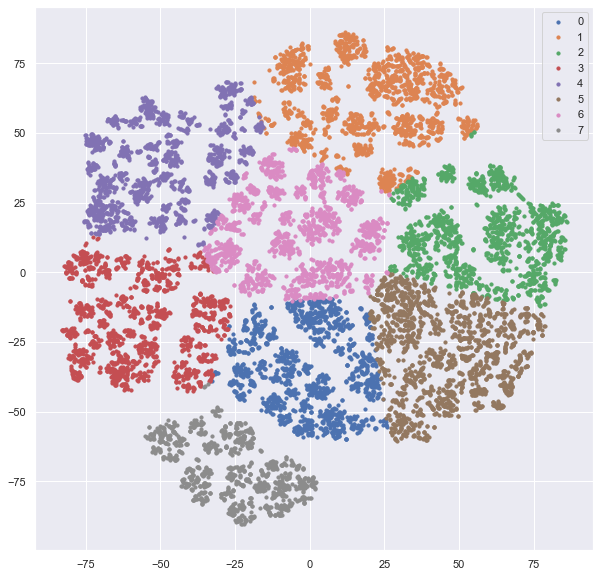

In [119]:
fig,ax = plt.subplots(figsize = (10,10))
for i in range(K_tsne):
    ax.scatter(x='t-SNE_1',y = 't-SNE_2',s = 10, data = t_sne_no_missing_df[t_sne_no_missing_df.cluster == i ],label = str(i))
plt.legend()

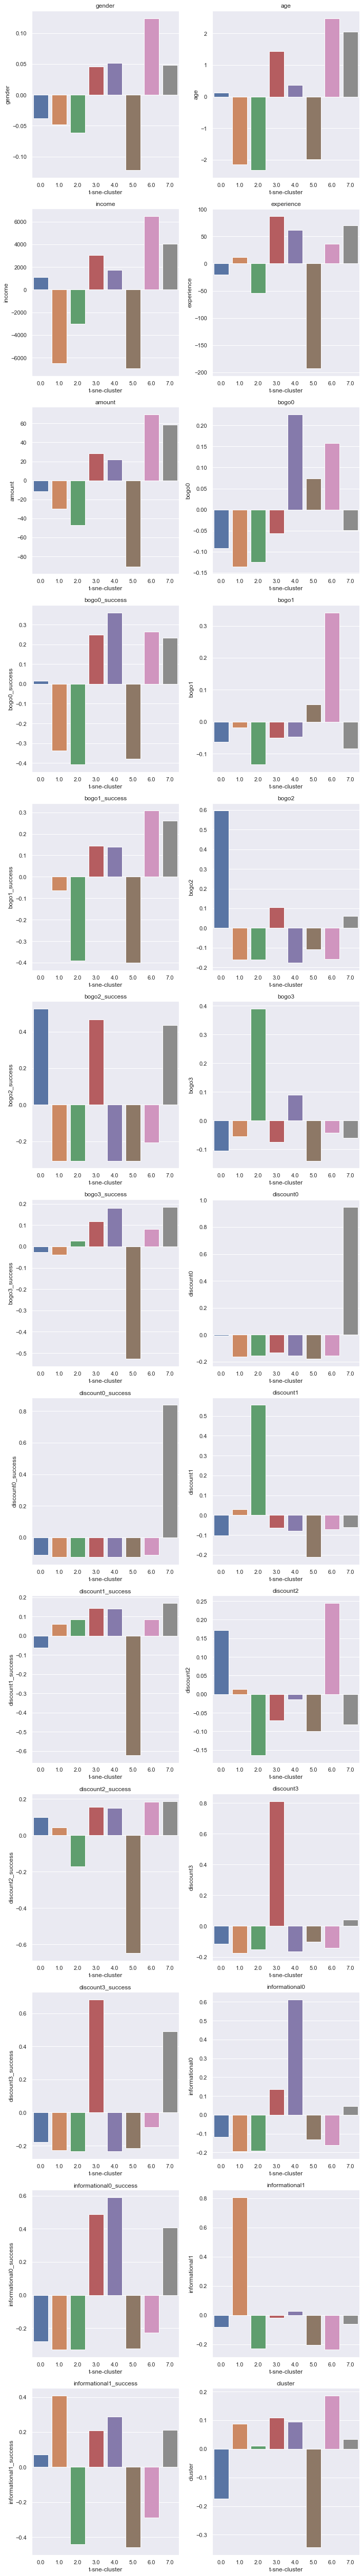

In [120]:
no_missing_regress['t-sne-cluster'] = t_sne_no_missing_df.cluster
#df_plot = no_missing_regress[['age','gender','income','experience','cluster','amount',]].groupby('cluster').mean()
sns.set();
df_plot = no_missing_regress.drop(['became_member_on','new_id'],axis = 1).groupby('t-sne-cluster').mean()
n_cols = df_plot.shape[1]
rows = n_cols//2 + (n_cols % 2 >0)
f, axs = plt.subplots(rows,2, figsize=(10,70))
axs = axs.flatten()
for i,col in enumerate(df_plot):
    #print(i)
    if 'success' in col:
        df_plot[col] = df_plot[col]/df_plot[col[:-len('_success')]]
    sns.barplot(x = df_plot.index, y = df_plot[col] - df_plot[col].mean(),ax = axs[i])#.plot(kind = 'bar',ax = axs[i])
    axs[i].set_title(col)
    #plt.show()
plt.tight_layout()

In [121]:
no_missing_df['t-sne-cluster'] = predicted_tsne_no_miss

In [122]:
no_missing_regress

,gender,age,became_member_on,income,new_id,experience,amount,bogo0,bogo0_success,bogo1,...,discount2,discount2_success,discount3,discount3_success,informational0,informational0_success,informational1,informational1_success,cluster,t-sne-cluster
1,1,55,20170715,112000.0,1,376,77.01,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
3,1,75,20170509,100000.0,3,443,159.27,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,0.0
5,0,68,20180426,70000.0,5,91,57.73,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,65,20180209,53000.0,8,167,36.43,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0
12,0,58,20171111,51000.0,12,257,15.62,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,1,45,20180604,54000.0,16995,52,20.03,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0
16996,0,61,20180713,72000.0,16996,13,25.97,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0
16997,0,49,20170126,73000.0,16997,546,39.74,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
16998,1,83,20160307,50000.0,16998,871,189.67,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6.0


## Missing value group

- Fit a PCA using transaction behavior and infer missing value group

In [125]:
missing = profile[profile.age == 118].copy()

In [126]:
missing_df = pd.merge(left = missing[['new_id','experience']], right = regression_df, left_on = 'new_id',right_index = True)

In [127]:
missing_df = missing_df.set_index('new_id')
missing_df.experience = missing_df.experience.dt.days

In [128]:
### change to rate
for col in missing_df:
    if 'success' in col:
        missing_df[col] = (missing_df[col]/missing_df[col[:-len('_success')]]).fillna(0)

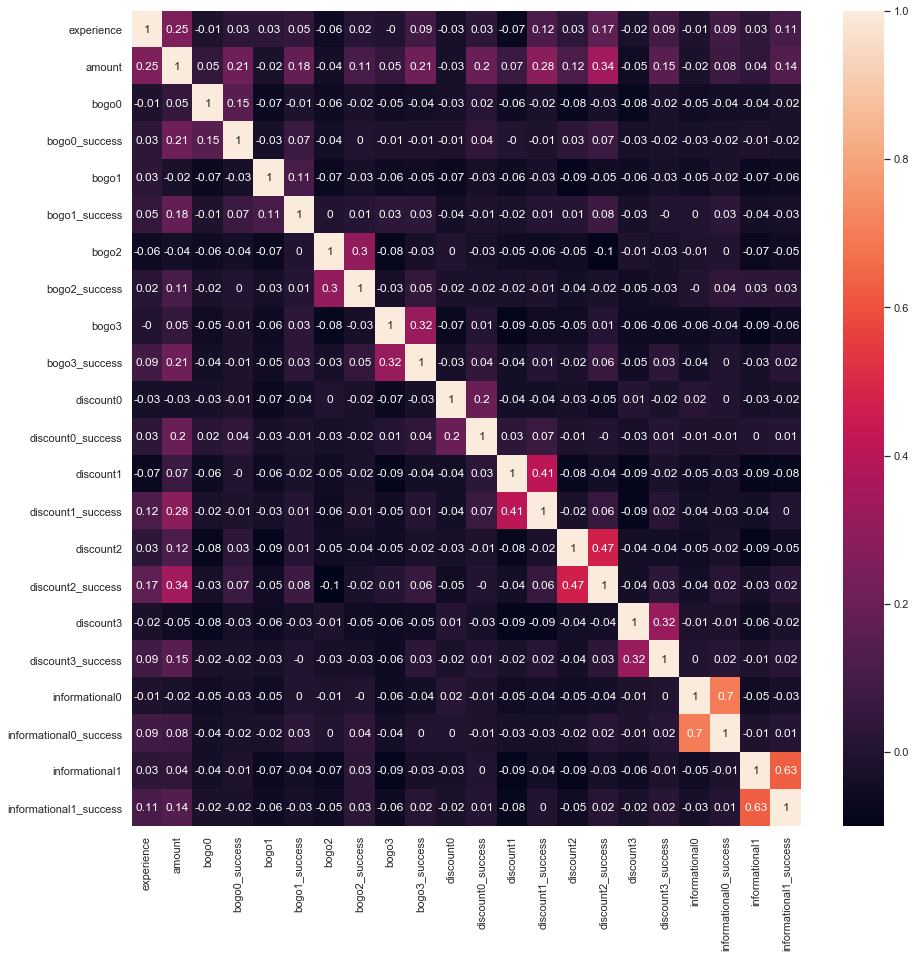

In [129]:
plt.figure(figsize = (15,15))
sns.heatmap(missing_df.corr().applymap(lambda x:round(x,2)),annot = True)

In [130]:
missing_transformed = preprocessing.StandardScaler().fit_transform(X = missing_df)

In [131]:
missing_df.head(2)

,experience,amount,bogo0,bogo0_success,bogo1,bogo1_success,bogo2,bogo2_success,bogo3,bogo3_success,...,discount1,discount1_success,discount2,discount2_success,discount3,discount3_success,informational0,informational0_success,informational1,informational1_success
new_id,,,,,,,,,,,,,,,,,,,,,
0,529,20.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,2.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0
2,14,14.3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [132]:
missing_tsne = TSNE(n_components = 2,random_state = 66).fit_transform(missing_transformed)

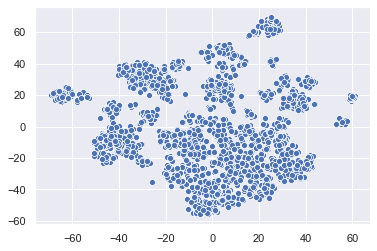

In [133]:
sns.scatterplot(missing_tsne[:,0],missing_tsne[:,1])

### Train a Random Forest Classifier to uncover customer structure of the missing value group
- First train on customers with "known" clusters trained from all features available
- Then I train a random forest using only features available for missing value group
- Apply the trained model on the missing value group

In [134]:
behavior_super = no_missing_regress.loc[:,'experience':]
y_insample = behavior_super['t-sne-cluster']
x_insample = behavior_super.loc[:,'experience':'informational1_success']

In [135]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline

In [136]:
behavior = make_pipeline(preprocessing.StandardScaler(),RandomForestClassifier())

In [137]:
behavior.get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('randomforestclassifier',
   RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                          max_depth=None, max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators='warn',
                          n_jobs=None, oob_score=False, random_state=None,
                          verbose=0, warm_start=False))],
 'verbose': False,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'randomforestclassifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity

In [138]:
RFparam_dict = {"randomforestclassifier__max_depth":[None,5,10,50]}
behavior_forest = GridSearchCV(estimator=behavior,param_grid = RFparam_dict,n_jobs=-1,cv = 4)

In [140]:
behavior_forest.fit(X = x_insample,y = y_insample.astype(int).astype(str))

F:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decre

In [216]:
from sklearn.metrics import f1_score

#### f-1 scores show that the random forest classifier performs well

In [220]:
f1_score(y_insample.astype(int),behavior_forest.predict(x_insample).astype(int),average = 'macro')

0.9970184596599923

In [221]:
f1_score(y_insample.astype(int),behavior_forest.predict(x_insample).astype(int),average = 'micro')

0.9968971332209107

In [141]:
missing_cluster = behavior_forest.predict(missing_df)

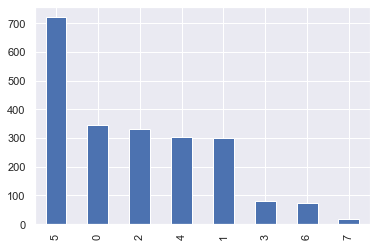

In [142]:
pd.DataFrame(missing_cluster)[0].value_counts().plot(kind = 'bar')

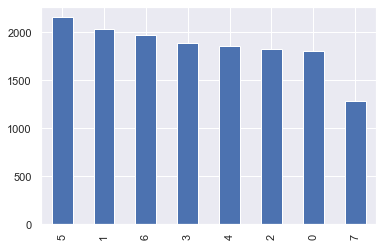

In [143]:
no_missing_regress['t-sne-cluster'].astype(int).value_counts().plot(kind = 'bar')

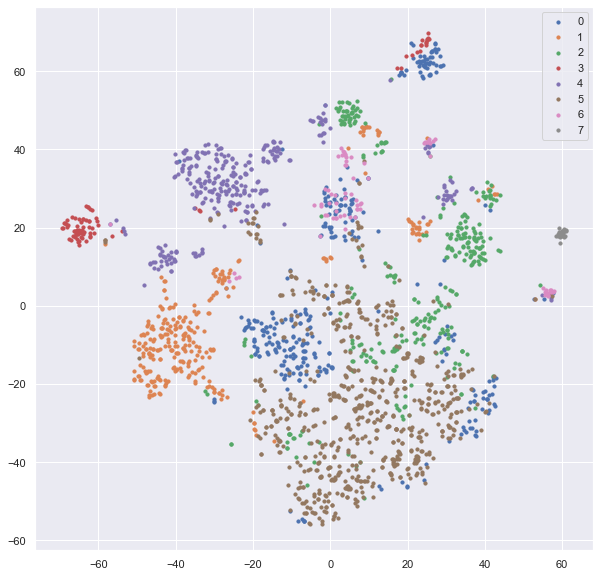

In [145]:
fig,ax = plt.subplots(figsize = (10,10))
behavior_missing_df = pd.DataFrame(np.c_[missing_tsne,missing_cluster],columns = ['t-SNE_1','t-SNE_2','behavior_cluster'])
for i in sorted(behavior_missing_df.behavior_cluster.unique()):
    ax.scatter(x='t-SNE_1',y = 't-SNE_2',s = 10, data = behavior_missing_df[behavior_missing_df.behavior_cluster == i ],label = str(i))
plt.legend()

In [146]:
missing_df['cluster'] = missing_cluster

#### Without behavior information, it's difficult to classify using experience plus even amount

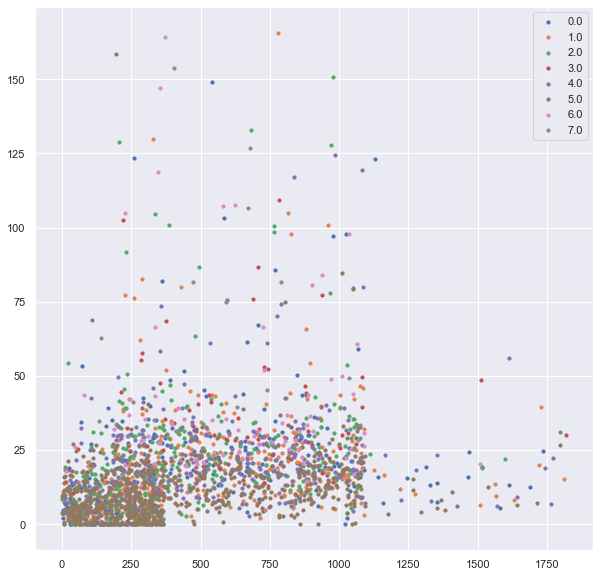

In [147]:
#sns.scatterplot(missing_df['experience'],missing_df['amount'],hue = missing_cluster.astype(int))
fig,ax = plt.subplots(figsize = (10,10))
behavior_missing_df = pd.DataFrame(np.c_[missing_df[['experience','amount']],missing_cluster.astype(int)],columns = ['experience','amount','behavior_cluster'])
for i in sorted(behavior_missing_df.behavior_cluster.unique()):
    ax.scatter(x='experience',y = 'amount',s = 10, data = behavior_missing_df[behavior_missing_df.behavior_cluster == i ],label = str(i))
plt.legend()

# Modeling

## No missing - in group causal analysis

In [148]:
import statsmodels.formula.api as smf

In [149]:
discount_dict = portfolio[['id','reward']].set_index('id').to_dict()['reward']

In [150]:
discount_dict

{'bogo0': 10,
 'bogo1': 10,
 'informational0': 0,
 'bogo2': 5,
 'discount0': 5,
 'discount1': 3,
 'discount2': 2,
 'informational1': 0,
 'bogo3': 5,
 'discount3': 2}

In [151]:
import re

In [152]:
test_df = no_missing_regress.copy()
test_df['adjusted_amount'] = test_df.amount
for i,col in enumerate(test_df):
    #print(i)
    if 'success' in col:
        test_df[col[:-len('_success')]+'_rate'] = (test_df[col]/test_df[col[:-len('_success')]]).fillna(0)
        test_df.adjusted_amount -= test_df[col] * discount_dict[col[:-len('_success')]]


In [153]:
test_df

,gender,age,became_member_on,income,new_id,experience,amount,bogo0,bogo0_success,bogo1,...,bogo0_rate,bogo1_rate,bogo2_rate,bogo3_rate,discount0_rate,discount1_rate,discount2_rate,discount3_rate,informational0_rate,informational1_rate
1,1,55,20170715,112000.0,1,376,77.01,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,75,20170509,100000.0,3,443,159.27,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0,68,20180426,70000.0,5,91,57.73,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,65,20180209,53000.0,8,167,36.43,0.0,0.0,0.0,...,0.0,0.0,0.5,1.0,0.0,0.0,1.0,1.0,0.0,0.0
12,0,58,20171111,51000.0,12,257,15.62,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,1,45,20180604,54000.0,16995,52,20.03,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16996,0,61,20180713,72000.0,16996,13,25.97,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16997,0,49,20170126,73000.0,16997,546,39.74,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16998,1,83,20160307,50000.0,16998,871,189.67,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
success_cols = [x for x in test_df.columns if re.search('success',x)]
rhs = ' + '.join(test_df.drop(['became_member_on','new_id','cluster','t-sne-cluster','amount','adjusted_amount']+success_cols,axis =1).columns)

In [155]:
formula = 'amount ~ ' + rhs

In [156]:
formula1 = formula[:-164]

### Correlation matrix suggest that multi-colinearity problem is serious
- From a business point of view, only keep the number of treatment is the best solution.
- Otherwise, it will be less interpretable

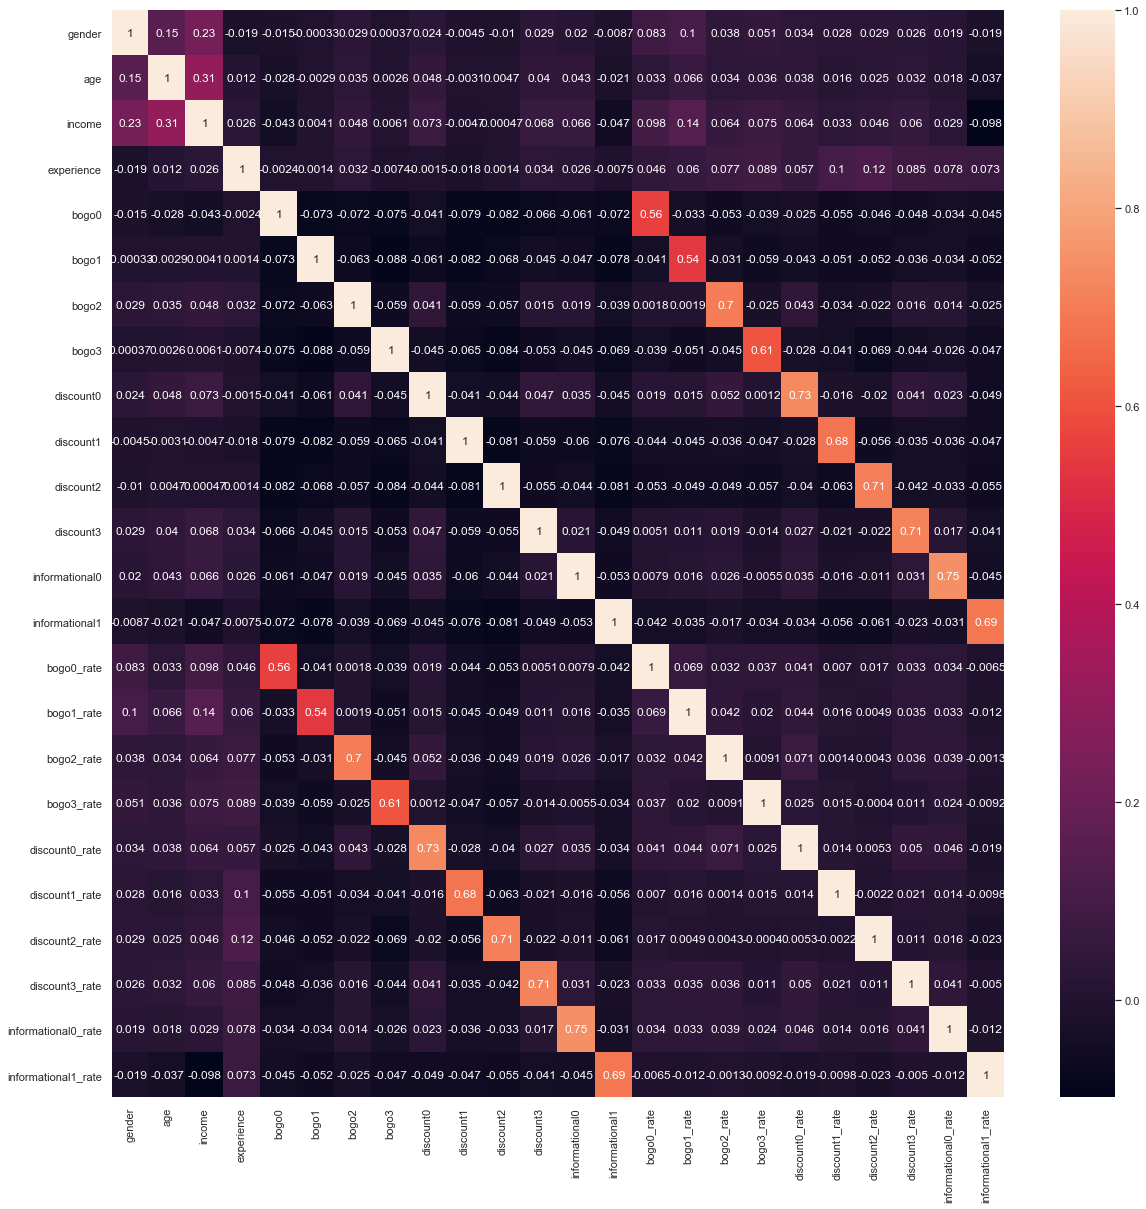

In [190]:
plt.figure(figsize = (20,20))
corr_df = test_df.drop(['became_member_on','new_id','cluster','t-sne-cluster','amount','adjusted_amount']+success_cols,axis =1).corr()
sns.heatmap(corr_df,annot = True)

In [192]:
formula

'amount ~ gender + age + income + experience + bogo0 + bogo1 + bogo2 + bogo3 + discount0 + discount1 + discount2 + discount3 + informational0 + informational1 + bogo0_rate + bogo1_rate + bogo2_rate + bogo3_rate + discount0_rate + discount1_rate + discount2_rate + discount3_rate + informational0_rate + informational1_rate'

In [193]:
formula1

'amount ~ gender + age + income + experience + bogo0 + bogo1 + bogo2 + bogo3 + discount0 + discount1 + discount2 + discount3 + informational0 + informational1'

In [194]:
formula2

'adjusted_amount ~gender + age + income + experience + bogo0 + bogo1 + bogo2 + bogo3 + discount0 + discount1 + discount2 + discount3 + informational0 + informational1 + bogo0_rate + bogo1_rate + bogo2_rate + bogo3_rate + discount0_rate + discount1_rate + discount2_rate + discount3_rate + informational0_rate + informational1_rate'

In [195]:
formula3

'adjusted_amount ~gender + age + income + experience + bogo0 + bogo1 + bogo2 + bogo3 + discount0 + discount1 + discount2 + discount3 + informational0 + informational1'

In [182]:
def group_regression(formula = formula1,group_col = 't-sne-cluster'):
    ''' Run a regression specified by formula on groups grouped by group_col
    Args:
        formula: str, in the form of "y ~ x1 + x2 + x3"
        group_col: str, column name used for group classification
    Return:
        param_df: DataFrame containing coefficients from different groups
        fig: the heatmap figure for visualizing the param_df
    '''
    param_df = {}
    for key, df in test_df.groupby(group_col):
        cluster_result = smf.ols(formula = formula,data = df).fit()
        param_df[key] = cluster_result.params
        print(key)
        print(cluster_result.summary())
    param_df = pd.DataFrame(param_df)
    param_df.index.name = 'Discount'
    param_df.columns.name = group_col
    target_index = [x for x in param_df.index.values if re.search('(discount|information|bogo)',x)]
    fig = plt.figure(figsize = (8,10))
    sns.heatmap(param_df.loc[target_index,:],annot = True)
    plt.title(formula.split('~')[0])
    return param_df,fig


In [158]:
test_df.bogo0_success.value_counts()

0.0    12509
1.0     2009
2.0      280
3.0       23
4.0        4
Name: bogo0_success, dtype: int64

In [159]:
formula

'amount ~ gender + age + income + experience + bogo0 + bogo1 + bogo2 + bogo3 + discount0 + discount1 + discount2 + discount3 + informational0 + informational1 + bogo0_rate + bogo1_rate + bogo2_rate + bogo3_rate + discount0_rate + discount1_rate + discount2_rate + discount3_rate + informational0_rate + informational1_rate'

0.0
                            OLS Regression Results                            
Dep. Variable:                 amount   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     41.02
Date:                Fri, 24 Apr 2020   Prob (F-statistic):          5.29e-151
Time:                        11:00:45   Log-Likelihood:                -10543.
No. Observations:                1809   AIC:                         2.114e+04
Df Residuals:                    1784   BIC:                         2.127e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -51.6990

F:\anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
F:\anaconda\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
F:\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
F:\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
F:\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


2.0
                            OLS Regression Results                            
Dep. Variable:                 amount   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     55.23
Date:                Fri, 24 Apr 2020   Prob (F-statistic):          1.29e-170
Time:                        11:00:45   Log-Likelihood:                -9983.1
No. Observations:                1828   AIC:                         2.001e+04
Df Residuals:                    1807   BIC:                         2.012e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -51.3522

6.0
                            OLS Regression Results                            
Dep. Variable:                 amount   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     52.32
Date:                Fri, 24 Apr 2020   Prob (F-statistic):          3.05e-190
Time:                        11:00:45   Log-Likelihood:                -12920.
No. Observations:                1969   AIC:                         2.589e+04
Df Residuals:                    1944   BIC:                         2.603e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -8.1356

(t-sne-cluster               0.0           1.0           2.0           3.0  \
 Discount                                                                    
 Intercept            -51.699049 -5.512673e+01 -5.135217e+01 -4.102424e+01   
 gender                13.223033  2.722512e+01  1.255511e+01  6.156238e+00   
 age                    0.229801 -1.961866e-02  3.885468e-03 -9.994858e-02   
 income                 0.001337  1.174202e-03  1.082543e-03  1.293140e-03   
 experience             0.018320  1.858398e-02  2.515975e-02  4.040058e-03   
 bogo0                 -2.416380 -1.052301e+01 -1.121346e+01 -2.849751e+00   
 bogo1                -14.316184 -5.449577e+00 -9.368851e+00 -1.469851e+01   
 bogo2                  5.099184  3.868557e+00  9.103726e-02  3.321357e+00   
 bogo3                -10.822957  2.498131e+00  3.411750e+00 -8.003254e+00   
 discount0            -12.238340  2.544204e-02 -6.069742e+00 -6.274424e-01   
 discount1              0.692388  3.108641e+00  8.428366e+00  5.

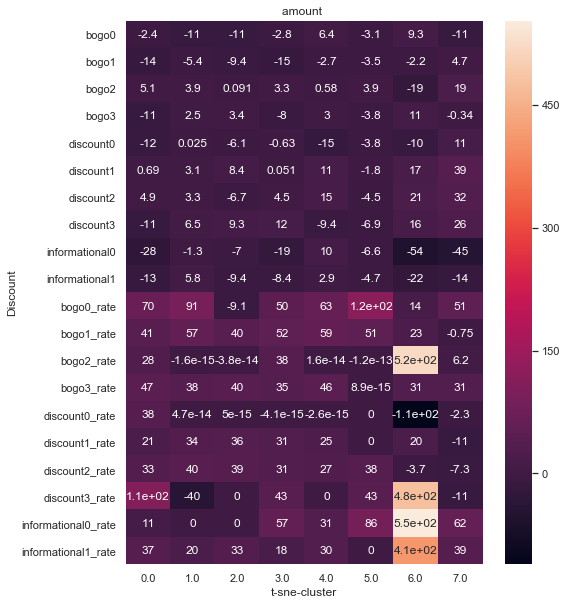

In [183]:
group_regression(formula,'t-sne-cluster')

In [161]:
formula2 = 'adjusted_amount ~' + rhs

0.0
                            OLS Regression Results                            
Dep. Variable:        adjusted_amount   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     34.20
Date:                Fri, 24 Apr 2020   Prob (F-statistic):          5.44e-128
Time:                        11:01:21   Log-Likelihood:                -10537.
No. Observations:                1809   AIC:                         2.112e+04
Df Residuals:                    1784   BIC:                         2.126e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -49.8611

F:\anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
F:\anaconda\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
F:\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
F:\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
F:\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


2.0
                            OLS Regression Results                            
Dep. Variable:        adjusted_amount   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     50.53
Date:                Fri, 24 Apr 2020   Prob (F-statistic):          5.67e-158
Time:                        11:01:21   Log-Likelihood:                -9975.3
No. Observations:                1828   AIC:                         1.999e+04
Df Residuals:                    1807   BIC:                         2.011e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -48.9804

strong multicollinearity or other numerical problems.
7.0
                            OLS Regression Results                            
Dep. Variable:        adjusted_amount   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     5.997
Date:                Fri, 24 Apr 2020   Prob (F-statistic):           6.77e-18
Time:                        11:01:22   Log-Likelihood:                -8124.2
No. Observations:                1287   AIC:                         1.630e+04
Df Residuals:                    1262   BIC:                         1.643e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

(t-sne-cluster               0.0           1.0           2.0           3.0  \
 Discount                                                                    
 Intercept            -49.861131 -5.412626e+01 -4.898042e+01 -3.807764e+01   
 gender                13.045356  2.702123e+01  1.250563e+01  5.964303e+00   
 age                    0.228170 -1.648138e-02  1.985199e-03 -1.089274e-01   
 income                 0.001333  1.169860e-03  1.079689e-03  1.290180e-03   
 experience             0.017909  1.845828e-02  2.469124e-02  3.814414e-03   
 bogo0                 -3.361995 -1.063170e+01 -1.122083e+01 -5.298737e+00   
 bogo1                -15.750854 -6.346170e+00 -9.262159e+00 -1.620713e+01   
 bogo2                  3.095733  3.784133e+00  4.380752e-02  1.707664e+00   
 bogo3                -11.437312  1.869019e+00  2.012997e+00 -8.964304e+00   
 discount0            -12.106269 -5.801176e-02 -5.919619e+00 -7.523839e-01   
 discount1              0.098973  2.410349e+00  7.090262e+00 -7.

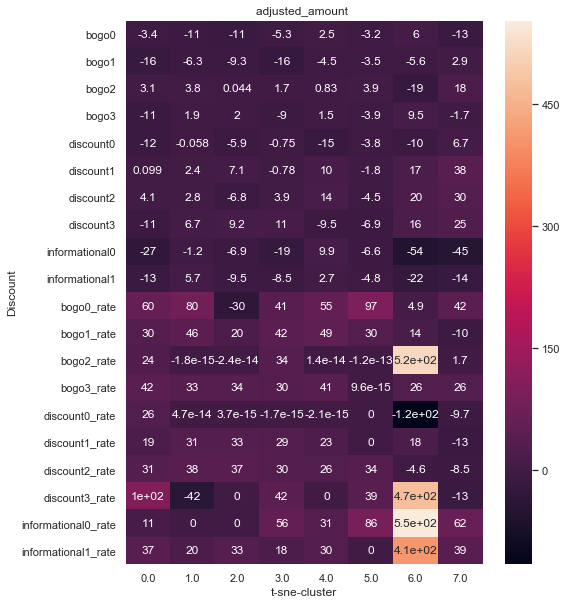

In [184]:
group_regression(formula2)

In [163]:
formula3 = formula2[:-164]

                            OLS Regression Results                            
Dep. Variable:        adjusted_amount   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     37.20
Date:                Fri, 24 Apr 2020   Prob (F-statistic):           5.15e-89
Time:                        10:56:05   Log-Likelihood:                -10649.
No. Observations:                1809   AIC:                         2.133e+04
Df Residuals:                    1794   BIC:                         2.141e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -55.3004     10.781     -5.

                            OLS Regression Results                            
Dep. Variable:        adjusted_amount   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     14.88
Date:                Fri, 24 Apr 2020   Prob (F-statistic):           1.33e-34
Time:                        10:56:06   Log-Likelihood:                -11321.
No. Observations:                1886   AIC:                         2.267e+04
Df Residuals:                    1871   BIC:                         2.276e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.7024     13.626     -0.

                            OLS Regression Results                            
Dep. Variable:        adjusted_amount   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     19.49
Date:                Fri, 24 Apr 2020   Prob (F-statistic):           1.54e-46
Time:                        10:56:06   Log-Likelihood:                -13274.
No. Observations:                1969   AIC:                         2.658e+04
Df Residuals:                    1954   BIC:                         2.666e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -49.9631     26.270     -1.

(t-sne-cluster         0.0        1.0        2.0        3.0        4.0  \
 Discount                                                                
 Intercept      -55.300394 -51.649541 -38.989692  -3.702426 -14.551818   
 gender          20.684454  32.827002  14.240604   9.047398  13.835341   
 age              0.252928  -0.032101   0.087853  -0.063280  -0.241046   
 income           0.001412   0.001395   0.001172   0.001284   0.001271   
 experience       0.033231   0.030924   0.040030   0.012574   0.020673   
 bogo0           19.983605  -5.461610 -13.705060  14.579192  19.820286   
 bogo1           -1.738091   9.937883  -8.824982   3.138805  14.228772   
 bogo2           16.097856   4.363952   1.434756  18.920041  -1.213902   
 bogo3            5.333329  14.155821   2.441056   6.825563  20.476959   
 discount0      -29.574844  -0.383042  -4.949230 -10.253660 -14.669109   
 discount1       11.255364  17.228587   8.999130  15.986313  24.323191   
 discount2       12.702120  20.683746 

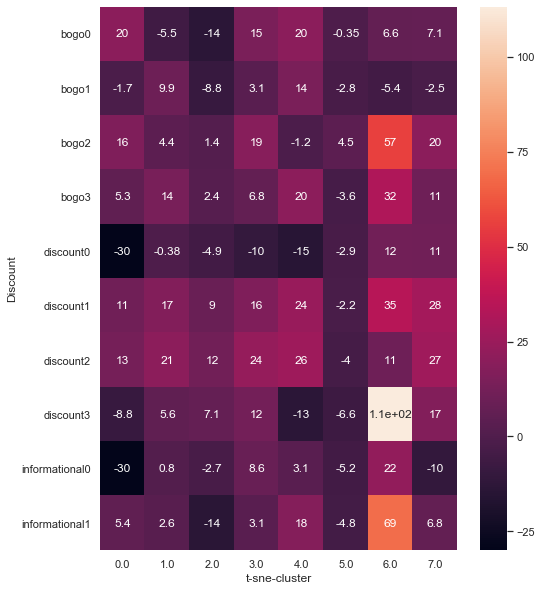

In [173]:
group_regression(formula3)

#### Examine and deal multi-colinearity

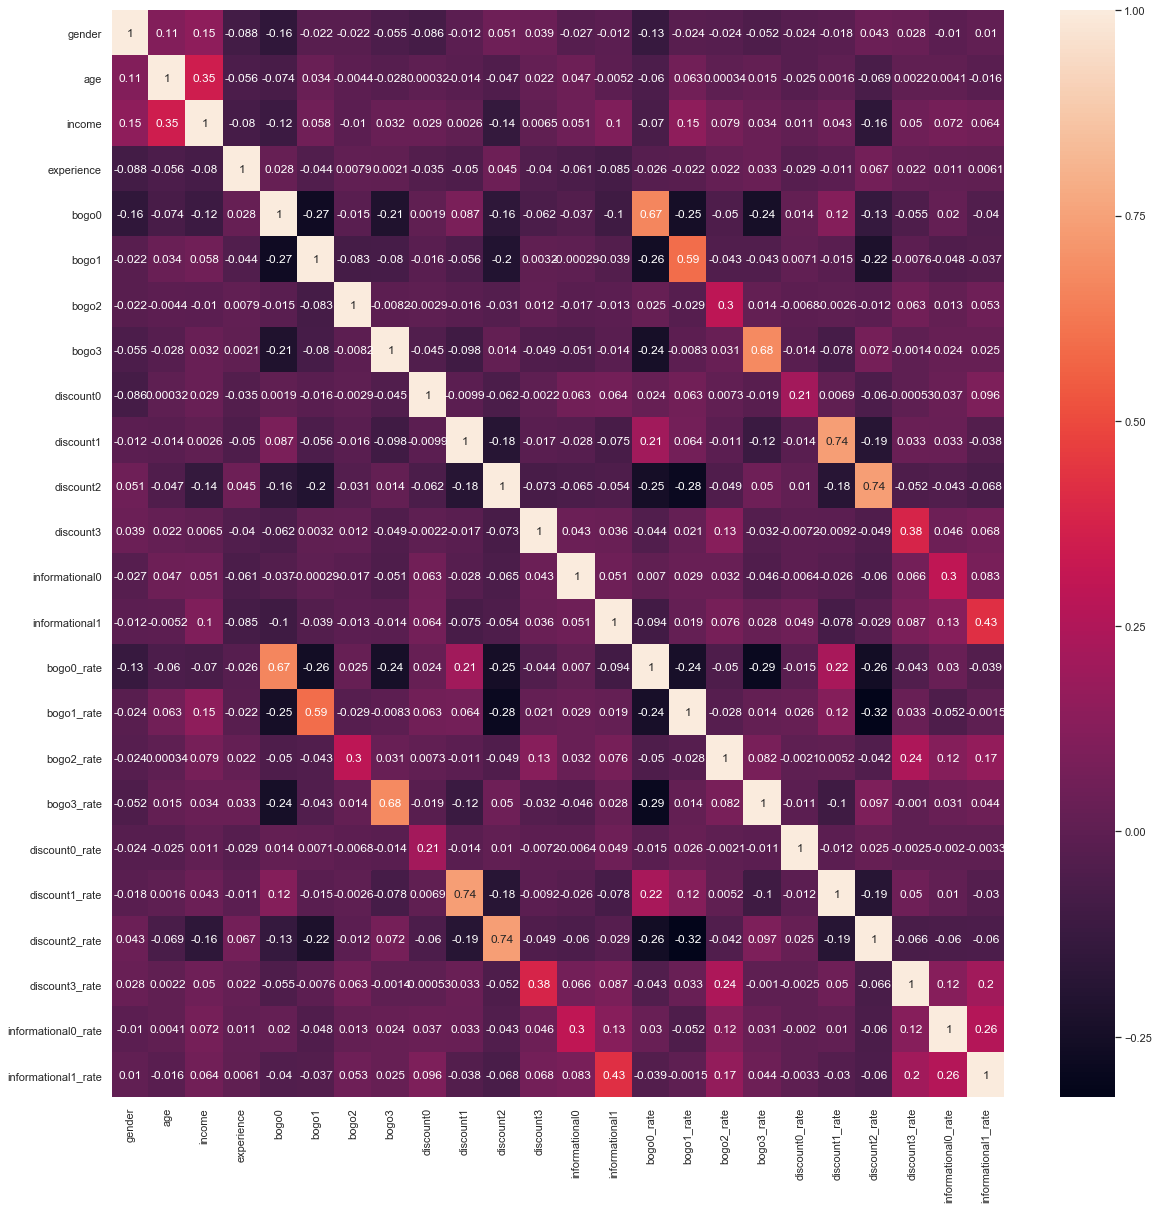

In [198]:
plt.figure(figsize = (20,20))
sns.heatmap(test_df[test_df['t-sne-cluster'] == 6].drop(['became_member_on','new_id','cluster','t-sne-cluster','amount','adjusted_amount']+success_cols,axis = 1).corr(),annot = True)

In [166]:
adjust_param_df = pd.DataFrame(adjust_param_df)

In [167]:
adjust_param_df.index.name = 'Discount'
adjust_param_df.columns.name = 't_SNE_cluster'

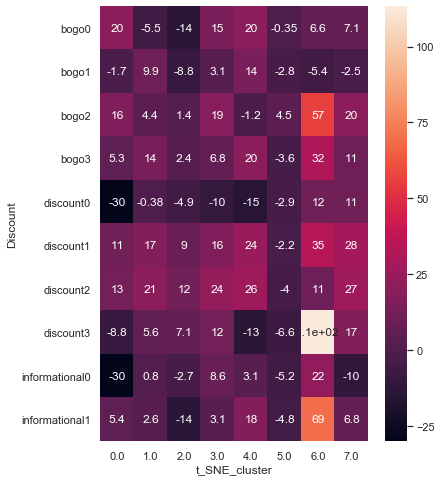

In [168]:
plt.figure(figsize = (6,8) )
sns.heatmap(adjust_param_df.iloc[5:,:],annot = True)

                            OLS Regression Results                            
Dep. Variable:                 amount   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     41.76
Date:                Fri, 24 Apr 2020   Prob (F-statistic):           2.19e-99
Time:                        10:51:07   Log-Likelihood:                -10686.
No. Observations:                1809   AIC:                         2.140e+04
Df Residuals:                    1794   BIC:                         2.148e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -59.2176     10.999     -5.

                            OLS Regression Results                            
Dep. Variable:                 amount   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     30.65
Date:                Fri, 24 Apr 2020   Prob (F-statistic):           7.46e-74
Time:                        10:51:08   Log-Likelihood:                -11005.
No. Observations:                1853   AIC:                         2.204e+04
Df Residuals:                    1838   BIC:                         2.212e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -16.3155     12.199     -1.

                            OLS Regression Results                            
Dep. Variable:                 amount   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     7.716
Date:                Fri, 24 Apr 2020   Prob (F-statistic):           7.51e-16
Time:                        10:51:08   Log-Likelihood:                -8149.0
No. Observations:                1287   AIC:                         1.633e+04
Df Residuals:                    1272   BIC:                         1.641e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5657     25.400      0.

(t-sne-cluster         0.0        1.0        2.0        3.0        4.0  \
 Discount                                                                
 Intercept      -59.217566 -55.709932 -40.273310  -7.073953 -16.315488   
 gender          22.143315  34.103826  14.636194   9.993960  14.870312   
 age              0.255235  -0.036804   0.099543  -0.048067  -0.232067   
 income           0.001441   0.001440   0.001188   0.001305   0.001302   
 experience       0.035434   0.032262   0.042331   0.013303   0.021493   
 bogo0           24.913080  -4.573419 -13.873718  21.578005  26.870995   
 bogo1            3.558231  14.278445  -8.307787   9.086414  19.889417   
 bogo2           20.387440   4.754380   1.816251  22.996494  -1.903169   
 bogo3            8.025475  16.614155   4.273742  10.264117  24.620823   
 discount0      -31.887995   0.084612  -4.911560 -10.732757 -14.286299   
 discount1       13.564099  19.427926  10.165545  18.349108  26.837711   
 discount2       13.486024  22.206347 

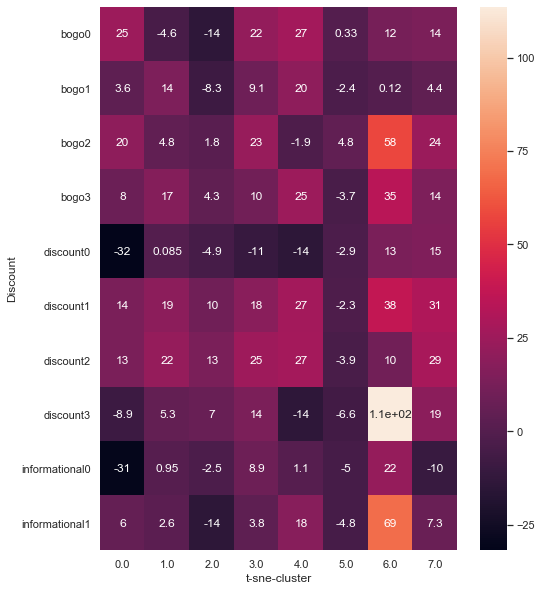

In [169]:
group_regression()

In [227]:
formula4 = re.sub('\+ income','',formula3)

0.0
                            OLS Regression Results                            
Dep. Variable:        adjusted_amount   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     23.87
Date:                Fri, 24 Apr 2020   Prob (F-statistic):           1.21e-53
Time:                        15:20:38   Log-Likelihood:                -10736.
No. Observations:                1809   AIC:                         2.150e+04
Df Residuals:                    1795   BIC:                         2.158e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.3760     10.185    

5.0
                            OLS Regression Results                            
Dep. Variable:        adjusted_amount   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     24.78
Date:                Fri, 24 Apr 2020   Prob (F-statistic):           1.56e-56
Time:                        15:20:38   Log-Likelihood:                -10844.
No. Observations:                2159   AIC:                         2.172e+04
Df Residuals:                    2145   BIC:                         2.180e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         13.3428      3.001    

(t-sne-cluster         0.0        1.0        2.0        3.0        4.0  \
 Discount                                                                
 Intercept        7.375954  11.224181  10.151527  53.998660  46.019088   
 gender          28.650974  46.004056  27.981027  16.185146  21.024070   
 age              0.738532   0.294795   0.462678   0.367280   0.248410   
 experience       0.032706   0.030735   0.043048   0.013970   0.019264   
 bogo0           19.159391  -9.218274 -18.985022  15.927147  19.406413   
 bogo1           -1.463460  11.258461 -10.639962   3.579276  11.565890   
 bogo2           17.861891   4.950178   0.013982  19.516882  -8.211650   
 bogo3            5.017549  14.422488   2.156202   6.185615  20.439168   
 discount0      -29.040168   2.410480   0.128185  -6.560818 -16.995082   
 discount1       11.580430  16.676356   8.622490  17.373911  23.218305   
 discount2       11.782593  22.237986  11.086620  24.608395  28.764246   
 discount3       -2.259490   7.830769 

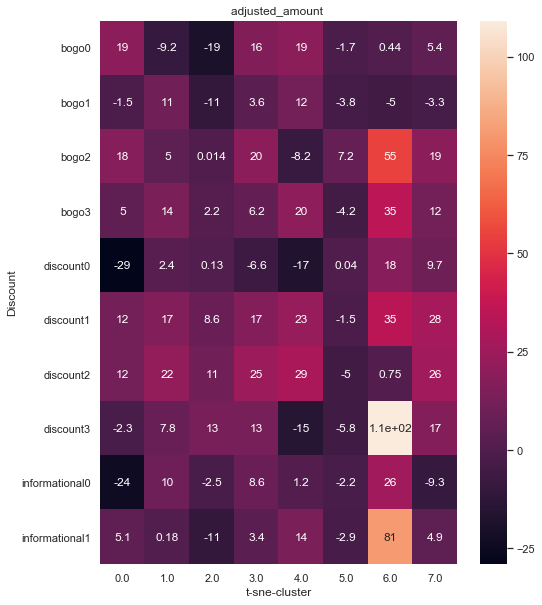

In [229]:
group_regression(formula4)

## Insight for business:

- Cluster 0: don't use information 0 / discount 0
- Cluster 1: discount 2 is particularly useful
- Cluster 2: discount is better than information/bogo
- Cluster 3: bogo 0/2 performs well
- Cluster 4: bogo0/3, discount1/2 is best, also information 1 very effective
- Cluster 5: best strategy is no offer
- Cluster 6: offers are particularly useful

### Check how cluster 6 is different

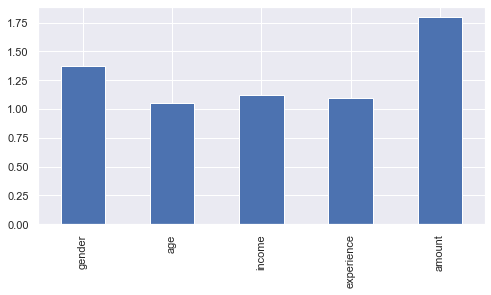

In [244]:
(test_df[test_df['t-sne-cluster'] == 6.0].drop(['new_id','became_member_on','cluster','t-sne-cluster'],axis = 1).mean()/test_df[test_df['t-sne-cluster'] != 6.0].drop(['new_id','became_member_on','cluster','t-sne-cluster'],axis = 1).mean())[:5].plot(figsize = (8,4),kind = 'bar')

- Spend much more: 75% more than others
- Age, experience, income slightly higher
- Ratio of femal is a lot higher ~ 30%

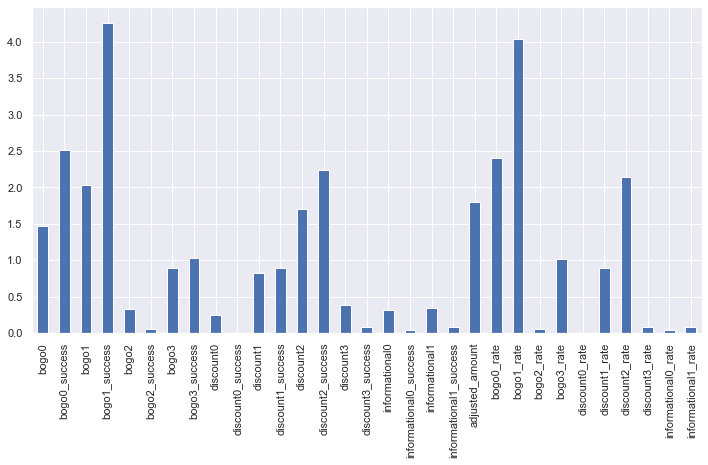

In [243]:
(test_df[test_df['t-sne-cluster'] == 6.0].drop(['new_id','became_member_on','cluster','t-sne-cluster'],axis = 1).mean()/test_df[test_df['t-sne-cluster'] != 6.0].drop(['new_id','became_member_on','cluster','t-sne-cluster'],axis = 1).mean())[5:].plot(figsize = (12,6),kind = 'bar')